In [1]:
import numpy as np
import pandas as pd
import math
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap as cmap
import pygbrowse

import scanpy as sc
import scvelo as scv
from harmony import harmonize

from scipy import stats
from tqdm.notebook import tqdm
import ipywidgets
from scipy.ndimage import gaussian_filter

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu 

### Functions

In [3]:
def scale_to_range(arr, new_min, new_max):
    return new_min + (arr - np.min(arr)) * (new_max - new_min) / (np.percentile(arr, 99) - np.min(arr))

In [4]:
def labels_to_rgb(data, label_order, hex_colors):
    label_order = list(label_order)
    label_idx = [label_order.index(label) for label in data]
    assert len(label_order) <= len(hex_colors), 'less `hex_colors` than unique `labels`'
    rgb_colors = list()
    for hex_color in hex_colors:
        rgb_colors.append([int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)])
    return np.array([rgb_colors[i] for i in label_idx])

### Plot settings

In [5]:
COLORS = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# presentation style
plt.matplotlib.rcParams['font.weight'] = 'normal'
plt.matplotlib.rcParams['axes.titleweight'] = 'normal'
plt.matplotlib.rcParams['axes.facecolor'] = plt.matplotlib.colors.to_hex((1., 1., 1., 1.), keep_alpha=True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = .25

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

OUTDIR = '/Users/prullens/Documents/manuscripts/invivo/figure1/'

### Global variables

In [6]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]

BINSIZE = 100000
SMOOTH_STDDEV = 150000

CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5'

chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMIDFN_BASE = '/Users/prullens/Documents/projects/invivo/experiments/{}/hdf5/{}.index{:02d}.DamID2_BC_{:03d}.top_n_2.event_counts.binsize_{}.hdf5'

### Data

In [7]:
gtf = pd.read_csv('/Users/prullens/metadata/mm10.Mus_musculus.GRCm38.89.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')

_pygBrowse_

In [8]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_Scanpy_

In [9]:
adata = sc.read_h5ad('/Users/prullens/data/projects/invivo/singlecell_lads_mouse_cortex.h5ad.gz')

adata

AnnData object with n_obs × n_vars = 5612 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    uns: 'cell_type_colors', 'construct_colors', 'construct_flattened_colors', 'embryo_colors', 'iue_colors', 'leiden_colors', 'limsid_colors', 'neighbors', 'rank_genes_groups', 'rank_genes_groups_cell_type'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distanc

In [10]:
anno = adata.obs.copy()

_DamID_

In [11]:
hdf5_list = [DAMIDFN_BASE.format(limsid,limsid,int(i),int(bc),BINSIZE) 
             for limsid,i,bc in adata.obs[['limsid','indexnr','damid2_barcodenr']].values
]

len(hdf5_list)

5612

In [12]:
depth_thrs = np.repeat(1000,len(hdf5_list))
depth_thrs[adata.obs['construct_flattened'] == 'Dam-only'] = 500

depth_thrs.size

5612

In [13]:
oe, depths = scct.compute_oe(hdf5_list, 
                             BINSIZE, 
                             CHROMSIZES, 
                             depth_thrs=depth_thrs, 
                             expected=EXPECTED %BINSIZE, 
                             blacklist=BLACKLIST, 
                             chroms=CHROMS
)
len(oe)

  0%|          | 0/5612 [00:00<?, ?it/s]

4448

In [14]:
oe_smooth = scct.gaussian_smoothing(oe, BINSIZE, SMOOTH_STDDEV, disable_tqdm=False)

  0%|          | 0/4448 [00:00<?, ?it/s]

_scATAC-seq (di Bella et al.)_

In [15]:
hdf5_list = glob('/Users/prullens/data/projects/invivo/GSE153164/scATAC/*binsize_500.rpkm.hdf5')

rpkm_atac, _ = scct.load_counts(hdf5_list, 500, chromsizes=CHROMSIZES, chroms=CHROMS, dtype=np.float32, disable_tqdm=True)
rpkm_atac = {k.split('.')[0].lower(): rpkm_atac[k] for k in rpkm_atac}

list(rpkm_atac)

['intermediate_progenitors', 'excitatory_neurons', 'apical_progenitors']

In [16]:
hdf5_list = glob('/Users/prullens/data/projects/invivo/GSE153164/scATAC/*binsize_100000.hdf5')

rpkm_atac_100kb, _ = scct.compute_oe(hdf5_list, 
                                     100_000, 
                                     CHROMSIZES, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS, 
                                     disable_tqdm=True
)
rpkm_atac_100kb = {k.split('.')[0].lower(): rpkm_atac_100kb[k] for k in rpkm_atac_100kb}

list(rpkm_atac_100kb)

No expected file found... Return RPKM values instead. In addition, unmappable regions are not set to pseudocount.


['intermediate_progenitors', 'apical_progenitors', 'excitatory_neurons']

### Plot

_Colors_

In [17]:
adata.uns['iue_colors'] = np.array(['#F46D43', #E13
                                    '#FEE08B', #E14
                                    '#66C2A5'], #E16
                                   dtype=object
)

In [18]:
adata.uns['cell_type_colors'] = np.array(['#1B7837', #PN1
                                          '#00441B',#PN2
                                          '#053061', #apical_progenitors
                                       '#4393C3', #intermediate_progenitors
                                       '#2020DF', #interneurons
                                       '#AFA5CF', #migrating_neurons
                                       '#543005'], #red_blood_cells
                                      dtype=object
)

In [19]:
cell_type_colors = dict(zip(adata.obs['cell_type'].cat.categories,adata.uns['cell_type_colors']))

cell_type_colors['excitatory_neurons'] = '#1B7837'

cell_type_colors

{'PN1': '#1B7837',
 'PN2': '#00441B',
 'apical_progenitors': '#053061',
 'intermediate_progenitors': '#4393C3',
 'interneurons': '#2020DF',
 'migrating_neurons': '#AFA5CF',
 'red_blood_cells': '#543005',
 'excitatory_neurons': '#1B7837'}

### RNA UMAP

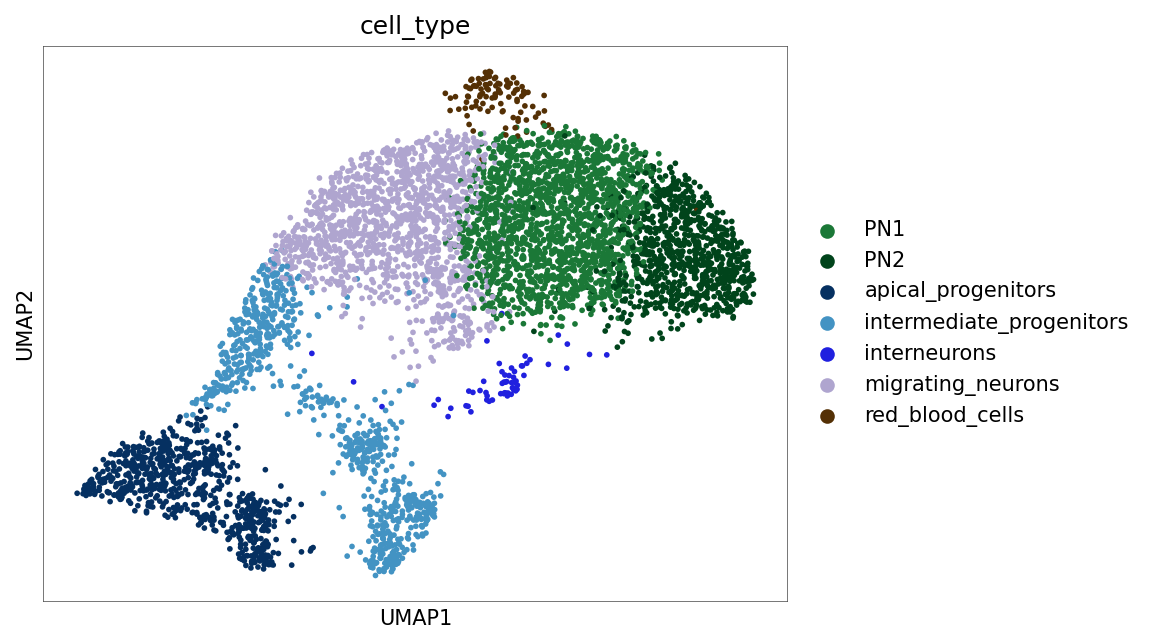

In [22]:
sc.pl.umap(adata, 
           color='cell_type',
           size=30,
)

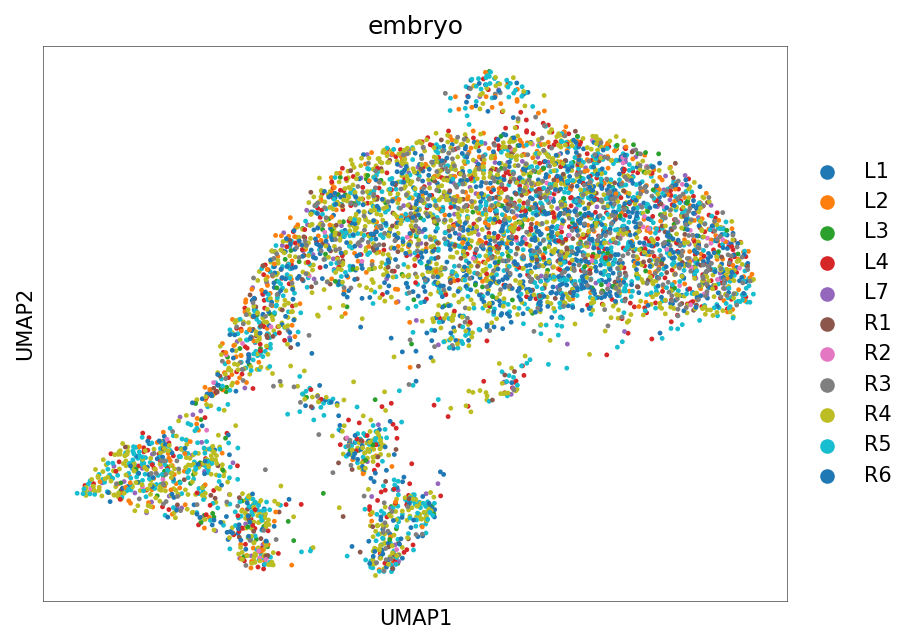

In [42]:
sc.pl.umap(adata, 
           color='embryo',
           legend_loc='right margin',
           palette=list(COLORS),
)

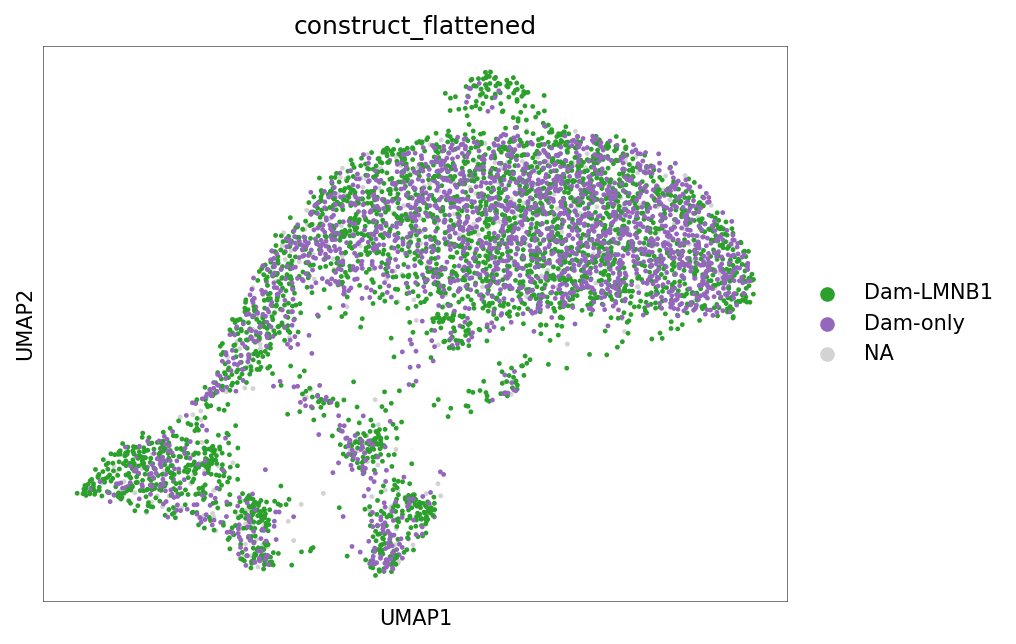

In [43]:
sc.pl.umap(adata, 
           color='construct_flattened',
           legend_loc='right margin',
           palette=[COLORS[2],COLORS[4]],
)

In [44]:
var_names = ['Hes5','Sox2','Pax6', #apical_progenitors
        'Eomes','Neurog2','Btg2', #intermediate_progenitors
        'Neurod2','Tubb3','Neurod6', #projection neurons
        'Dlx1','Dlx2','Gad2', #interneurons
        'Hba-a1','Hbb-bs','Hba-a2'#red_blood_cells
]
len(var_names)

15

[<Axes: title={'center': 'Hes5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Sox2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Pax6'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Eomes'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Neurog2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Btg2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Neurod2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Tubb3'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Neurod6'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Dlx1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Dlx2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Gad2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Hba-a1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Hbb-bs'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Hba-a2'}, xlabel='UMA

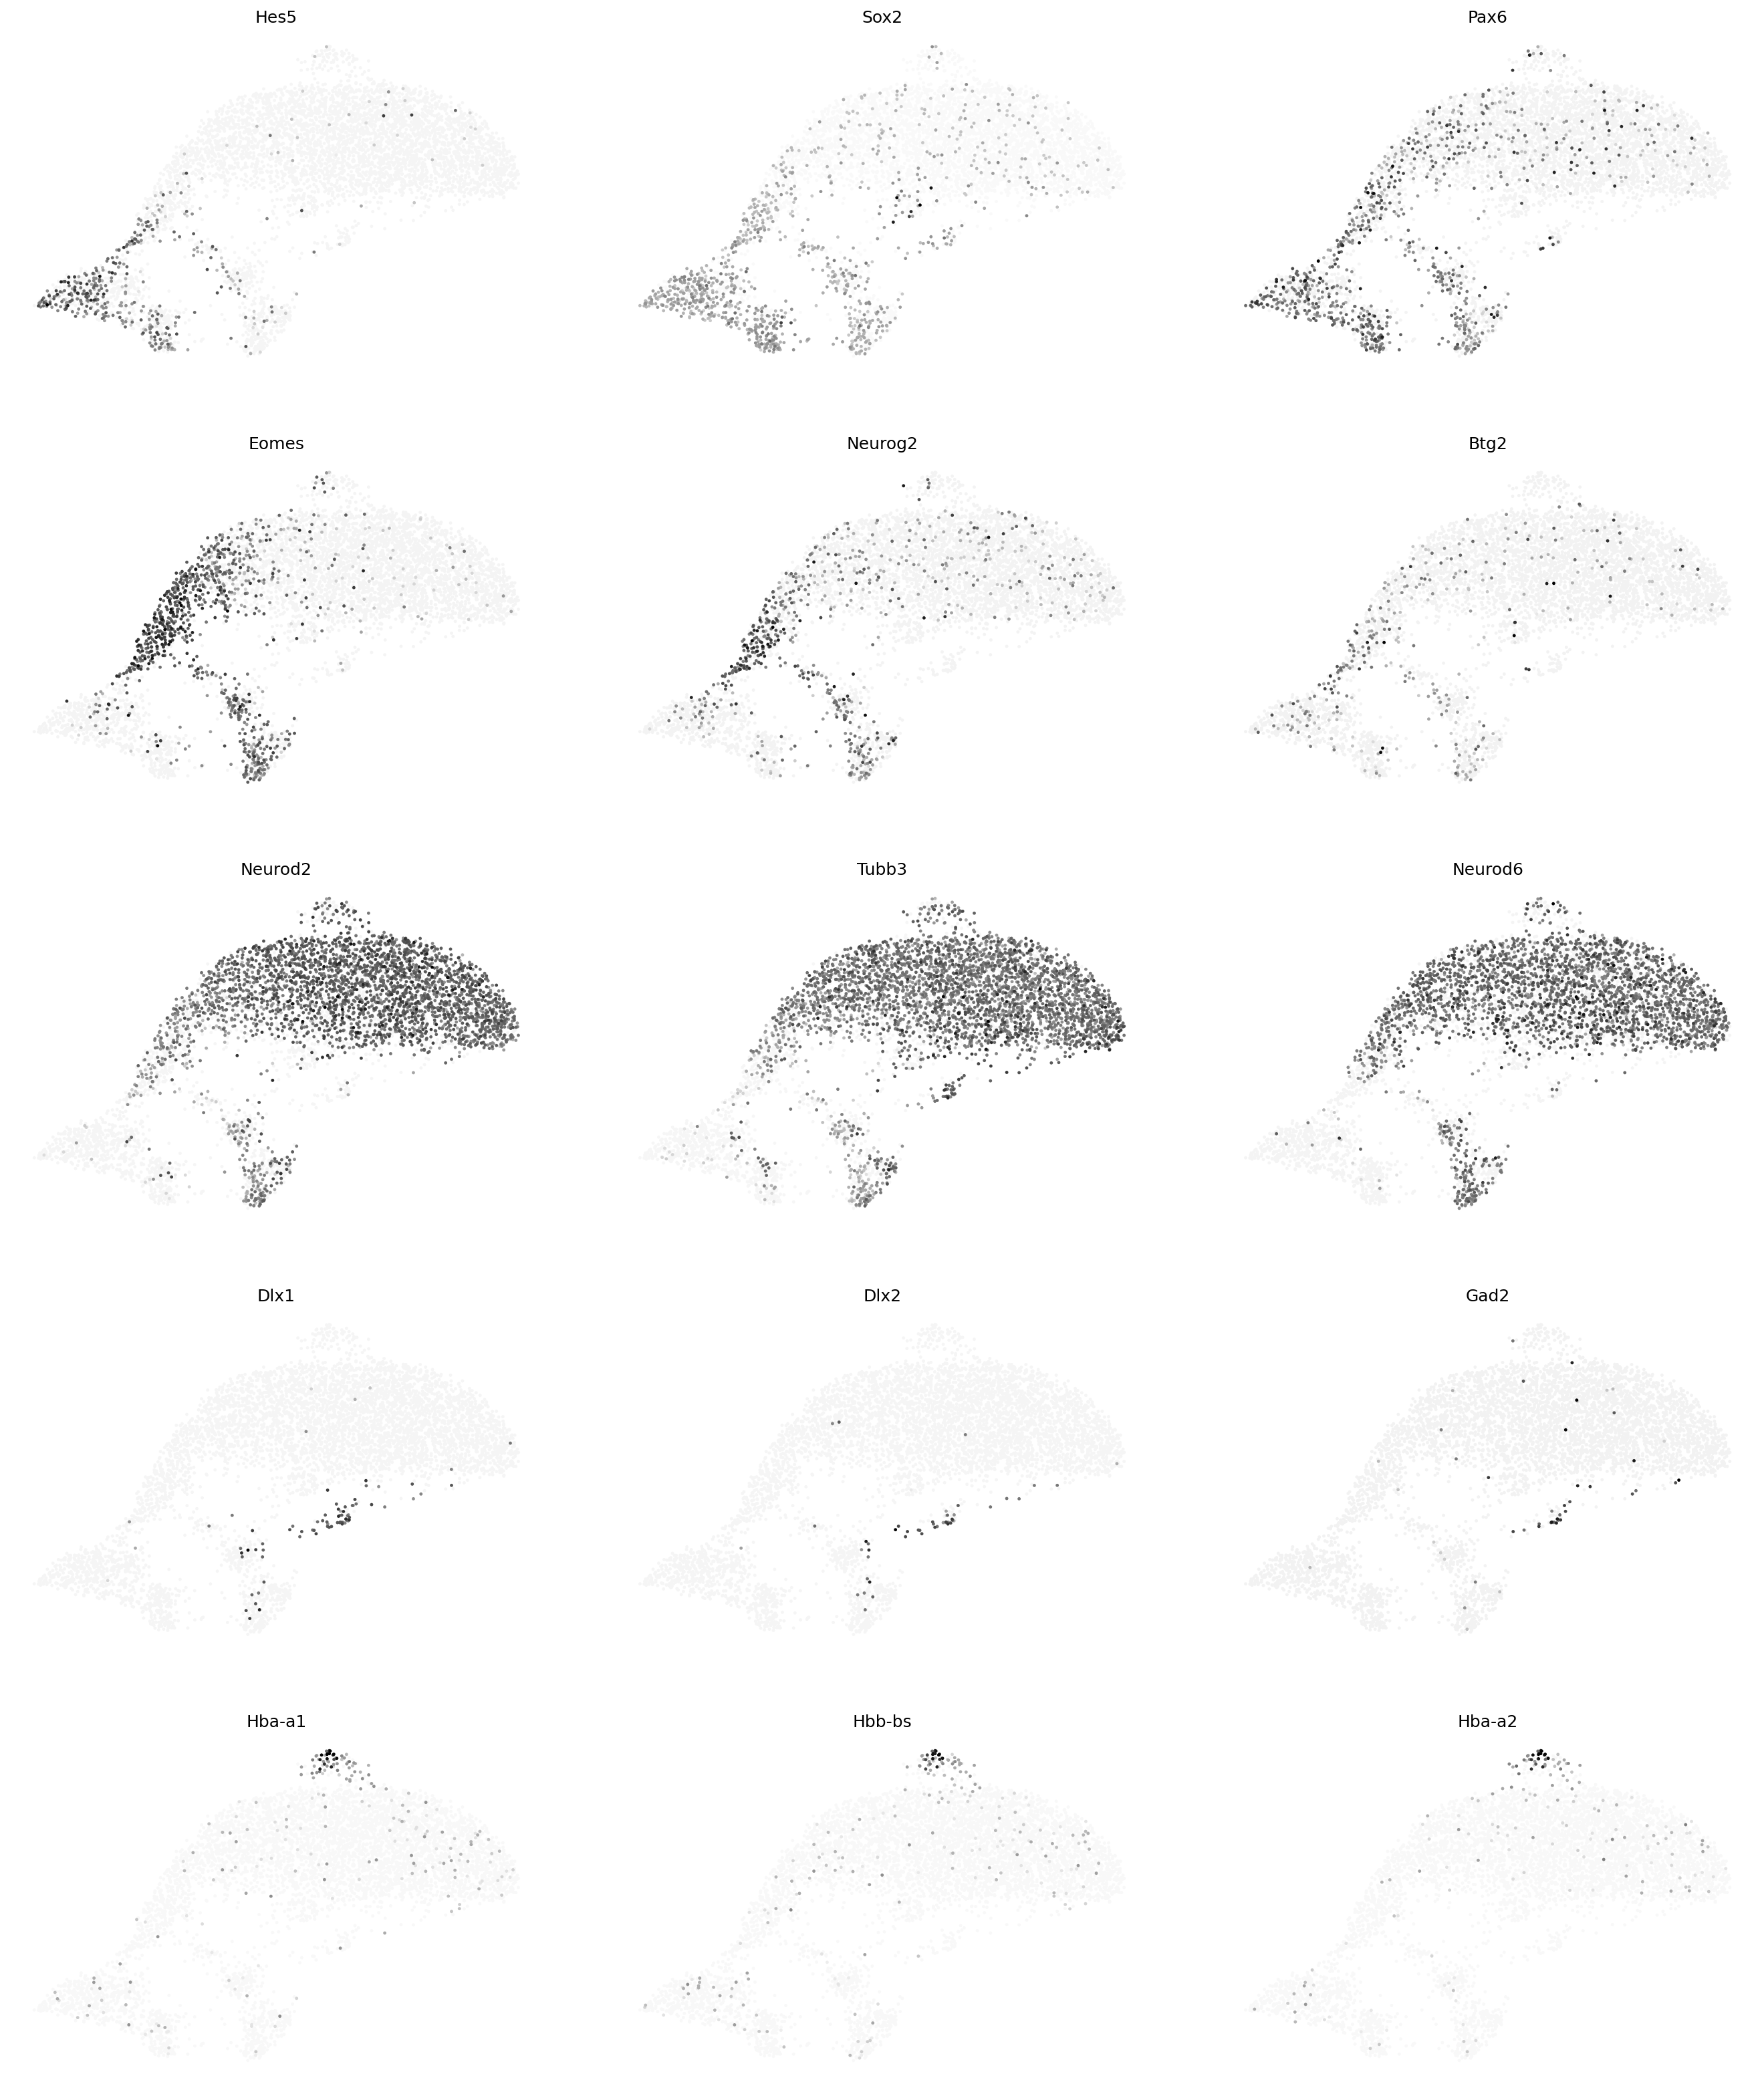

In [45]:
sc.pl.umap(adata, 
           color=var_names, #np.hstack(np.array(vars).reshape(7,-1).T),
           layer='count_abundance_genes_from_celseq2_data',
           frameon=False,
           colorbar_loc=None,
           cmap='Greys',
           vmin=-.5,
           ncols=3, #7
           show=False,
)

### _di Bella et al._ atlas 

In [46]:
adata_db = sc.read_h5ad('/Users/prullens/data/projects/invivo/invivo_merged_dibella.h5ad.gz')

adata_db

AnnData object with n_obs × n_vars = 30462 × 2000
    obs: 'batch', 'collection', 'Gral_cellType', 'New_cellType', 'total_counts', 'pct_counts_mt', 'lab', 'construct_flattened', '_construct_flattened', 'leiden', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'cellcycle_phase', 'g2m_fraction', 's_fraction'
    var: 'Accession', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Gral_cellType_colors', 'New_cellType_colors', 'batch_colors', 'cellcycle_phase_colors', 'collection_colors', 'construct_flattened_colors', 'cycling_colors', 'hvg', 'lab_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony_lab', 'X_pca_harmony_lab_batch', 'X_pca_harmony_lab_batch_construct', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

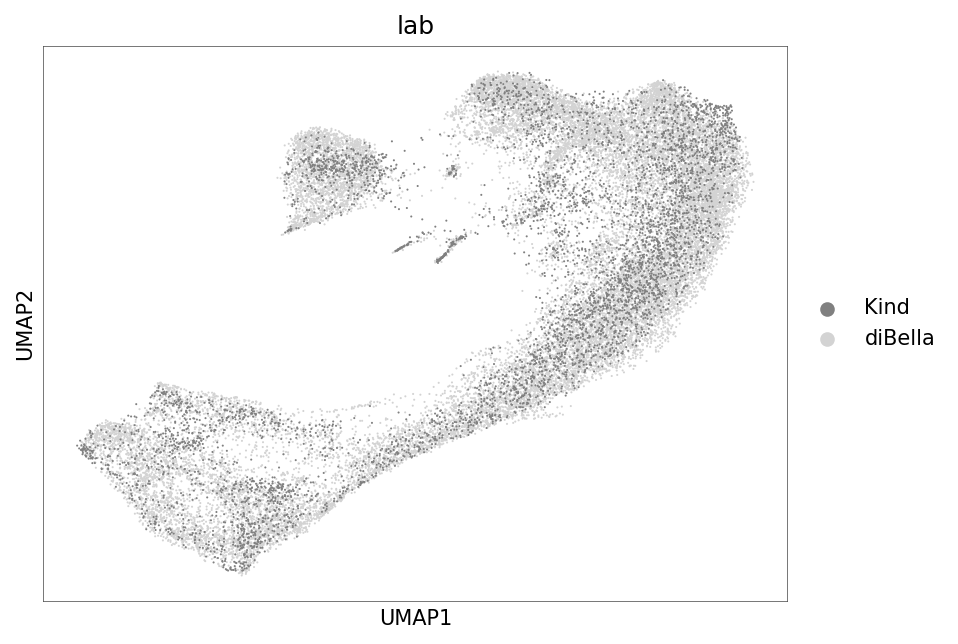

In [49]:
sc.pl.umap(adata_db, 
            color='lab', 
            palette=['grey','lightgrey'],
           legend_loc='right margin',
)

In [50]:
adata_db.uns['Gral_cellType_colors'] = np.array(['#053061', #Apical progenitors
                                                 '#1B7837', #Excitatory neurons
                                                 '#4393C3', #Intermediate progenitors
                                                 '#2020DF', #Interneurons
                                                 '#FA9FB5', #Microglia
                                                 '#D3D3D3', #Null
                                                 '#FDCD3C'],#Vasculature
                                                dtype=object
)

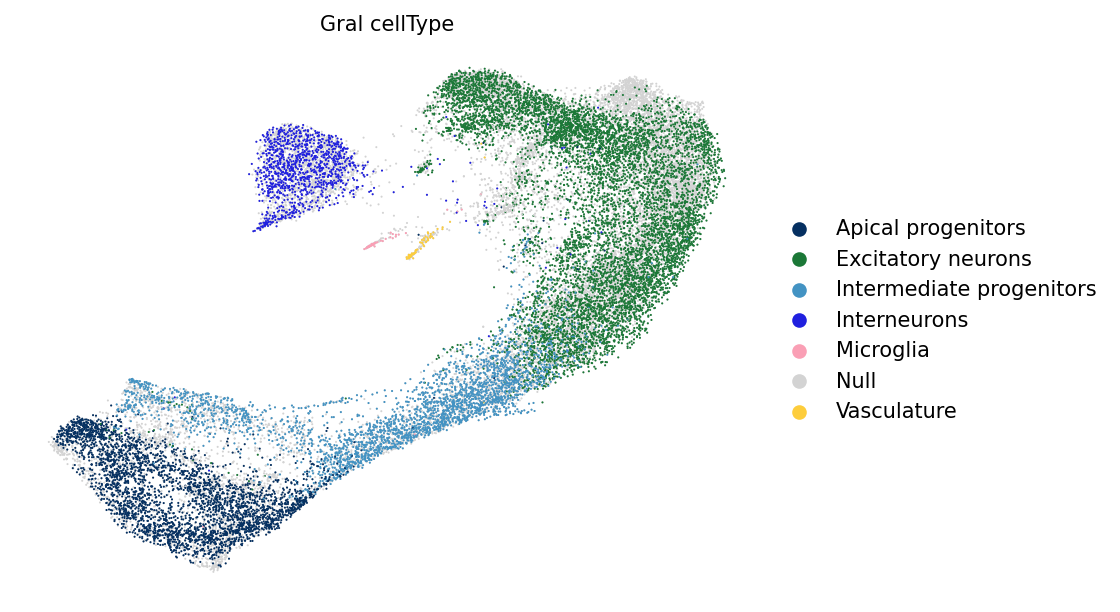

In [52]:
scv.pl.umap(adata_db, 
            color='Gral_cellType', 
            legend_loc='right_margin',
)

_____

In [54]:
celltypes_k = np.ravel(adata.obs['cell_type'])

celltypes_k[np.isin(celltypes_k, ['migrating_neurons','PN1','PN2'])] = 'excitatory_neurons'

celltypes_k = celltypes_k[np.isin(celltypes_k, ['apical_progenitors','intermediate_progenitors','excitatory_neurons','interneurons'])]

In [55]:
celltypes_db = np.ravel(adata_db.obs.loc[adata_db.obs['lab'] == 'diBella','Gral_cellType'])

celltypes_db[celltypes_db == 'Apical progenitors'] = 'apical_progenitors'
celltypes_db[celltypes_db == 'Intermediate progenitors'] = 'intermediate_progenitors'
celltypes_db[celltypes_db == 'Excitatory neurons'] = 'excitatory_neurons'
celltypes_db[celltypes_db == 'Interneurons'] = 'interneurons'

celltypes_db = celltypes_db[np.isin(celltypes_db, ['apical_progenitors','intermediate_progenitors','excitatory_neurons','interneurons'])]

In [56]:
labels_k, counts_k = np.unique(celltypes_k, return_counts=True)
labels_db, counts_db = np.unique(celltypes_db, return_counts=True)

X = np.r_[labels_k,labels_db] 
y = np.r_[counts_k / counts_k.sum(),counts_db / counts_db.sum()]
hue = np.repeat(['Kind','diBella'],labels_k.size)
 
X.size, y.size, hue.size

(8, 8, 8)

Text(0, 0.5, 'Fraction of cells')

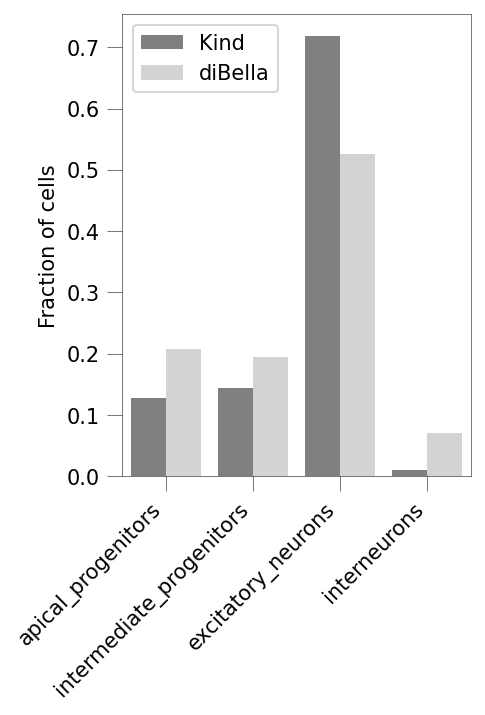

In [57]:
f, ax = plt.subplots(figsize=(3,4))

sns.barplot(x=X, 
            y=y, 
            hue=hue, 
            order=['apical_progenitors','intermediate_progenitors','excitatory_neurons','interneurons'],
            palette=['grey','lightgrey'],
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Fraction of cells')

_____

____

### Unique counts

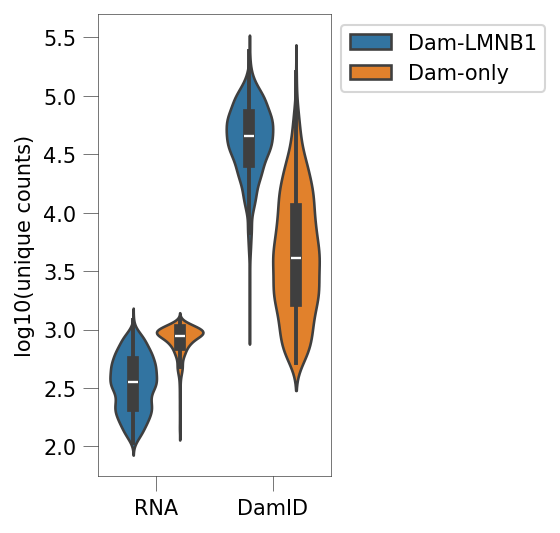

In [97]:
X = np.tile(['RNA','DamID'], anno['damid'].astype(bool).sum())
y = np.log10(np.hstack(anno.loc[anno['damid'],['total_counts','dam_counts']].values))
hue = np.repeat(anno.loc[anno['damid'],'construct_flattened'], 2)

f, ax = plt.subplots(figsize=(2,4))

sns.violinplot(x=X, y=y, hue=hue, scale='count')

ax.legend(bbox_to_anchor=(1,1))

ax.set_ylabel('log10(unique counts)')
ax.minorticks_off()
plt.tight_layout()

_____

# Chromatin accessibility (Dam126)

### TSS fraction vs. depth

In [58]:
#2kb up and downstream of TSS --> same as pyCistopic et al. 
adata_tss = sc.read_10x_mtx('/Users/prullens/data/projects/invivo/dam_macs2/filtered_feature_tss_bc_matrix/')
adata_tss.obs = adata[adata_tss.obs_names].obs.copy()
adata_tss.obs['tss_fraction'] = np.ravel(adata_tss.X.sum(1)) / adata_tss.obs['dam_counts'].values

adata_tss

AnnData object with n_obs × n_vars = 1769 × 52004
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid', 'tss_fraction'
    var: 'gene_ids', 'feature_types'

<Axes: xlabel='dam_counts', ylabel='tss_fraction'>

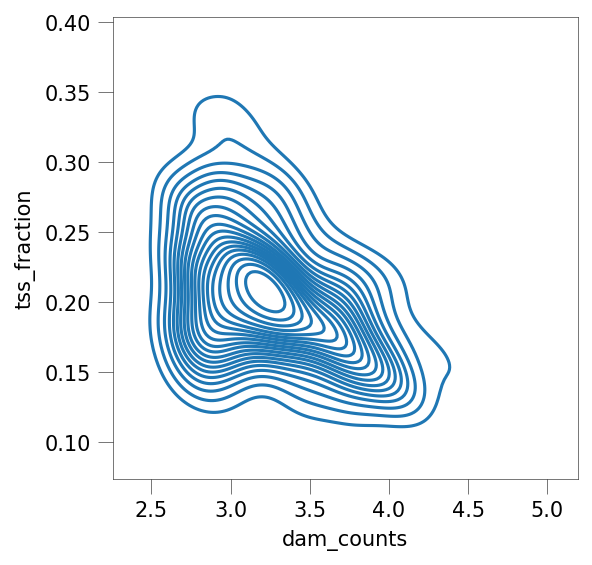

In [59]:
f, ax = plt.subplots(figsize=(4,4), dpi=150)

sns.kdeplot(x=np.log10(adata_tss.obs['dam_counts']), 
                y=adata_tss.obs['tss_fraction'], 
                hue=adata_tss.obs['construct'],
                hue_order=['EF1aDam126'],
            levels=20,
            legend=False
)


### Locus specific plots

In [64]:
binsize = 500
hdf5_list = sorted(glob(f'/Users/prullens/data/projects/invivo/dam_macs2/hdf5/PR20240730.*.damid2.*.binsize_{binsize}.hdf5'))

rpkm, depths = scct.compute_oe(hdf5_list, 
                               binsize, 
                               CHROMSIZES, 
                               blacklist=BLACKLIST, 
                               expected=EXPECTED %binsize,
                               chroms=CHROMS, 
                               disable_tqdm=False
)
labels = ['PN2',
 'PN1',
 'apical_progenitors',
 'intermediate_progenitors',
 'interneurons',
 'migrating_neurons',
 'red_blood_cells']

rpkm = {labels[i]: rpkm[k] for i,k in enumerate(rpkm)}

list(rpkm)

  0%|          | 0/7 [00:00<?, ?it/s]

['PN2',
 'PN1',
 'apical_progenitors',
 'intermediate_progenitors',
 'interneurons',
 'migrating_neurons',
 'red_blood_cells']

In [65]:
smooth_stddev = 500

rpkm_smooth = scct.gaussian_smoothing(rpkm, binsize, smooth_stddev, disable_tqdm=False)

  0%|          | 0/7 [00:00<?, ?it/s]

In [66]:
rpkm_smooth_scaled = dict()
for sample in tqdm(rpkm_smooth):
    rpkm_smooth_scaled[sample] = {c: scale_to_range(rpkm_smooth[sample][c], 0, 10) for c in CHROMS}

  0%|          | 0/7 [00:00<?, ?it/s]

____

In [67]:
cell_types = ['apical_progenitors','intermediate_progenitors','migrating_neurons','PN1','PN2']

len(cell_types)

5

Text(0.5, 0, 'Chromosome 12 (Mb)')

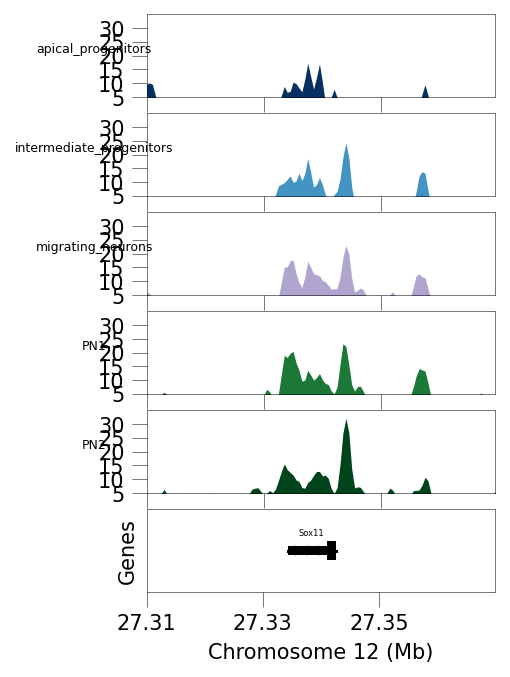

In [68]:
chrom = '12' #Sox11
s = 27310000
e = 27370000

xaxis = np.arange(s,e,binsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
                     dpi=150
)

ymin, ymax = 5, 35
for i,cell_type in enumerate(cell_types):
    y = gaussian_filter(rpkm_smooth_scaled[cell_type][chrom][s//binsize:e//binsize], 0)

    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,20_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,20_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,20_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

Text(0.5, 0, 'Chromosome 12 (Mb)')

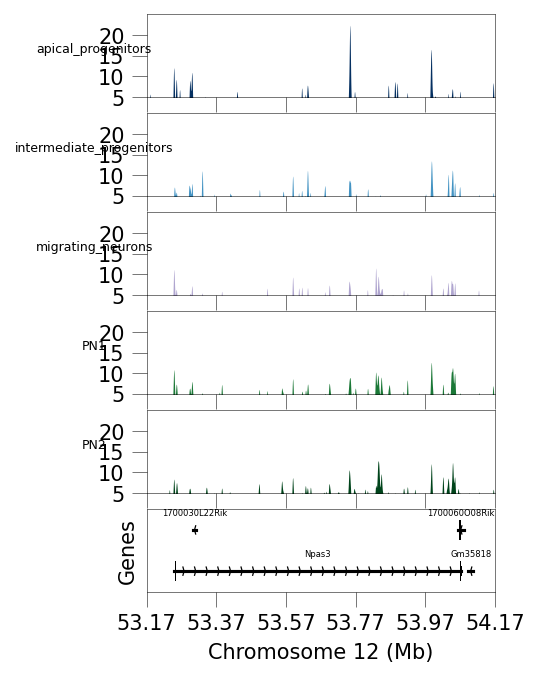

In [70]:
chrom = '12' #Npas3
s = 53169000 
e = 54170000

xaxis = np.arange(s,e,binsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
                     dpi=150
)

ymin, ymax = 5, 25
for i,cell_type in enumerate(cell_types):
    y = gaussian_filter(rpkm_smooth_scaled[cell_type][chrom][s//binsize:e//binsize], 3)

    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,200_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,200_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,200_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

Text(0.5, 0, 'Chromosome 8 (Mb)')

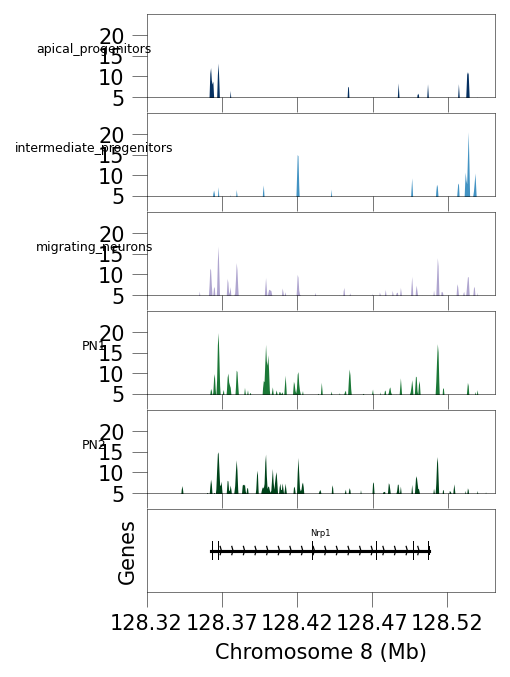

In [72]:
chrom = '8' #Nrp1
s = 128315500
e = 128547500

xaxis = np.arange(s,e,binsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
                     dpi=150
)

ymin, ymax = 5, 25
for i,cell_type in enumerate(cell_types):
    y = gaussian_filter(rpkm_smooth_scaled[cell_type][chrom][s//binsize:e//binsize], 0)

    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,50_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,50_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,50_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

Text(0.5, 0, 'Chromosome 16 (Mb)')

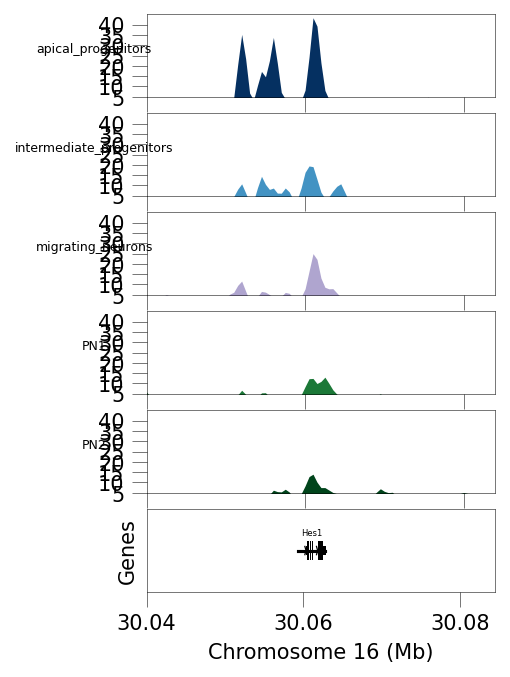

In [75]:
chrom = '16' #Hes1
s = 30045000
e = 30089500

xaxis = np.arange(s,e,binsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
                     dpi=150
)

ymin, ymax = 5, 45
for i,cell_type in enumerate(cell_types):
    y = gaussian_filter(rpkm_smooth_scaled[cell_type][chrom][s//binsize:e//binsize], 0)

    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,20_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,20_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,20_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

____

In [77]:
cell_types_atac = ['apical_progenitors','intermediate_progenitors','excitatory_neurons']

cell_types_atac

['apical_progenitors', 'intermediate_progenitors', 'excitatory_neurons']

Text(0.5, 0, 'Chromosome 8 (Mb)')

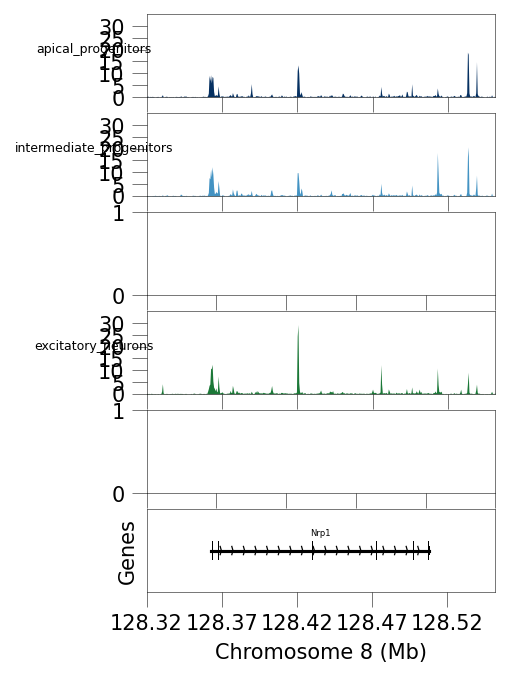

In [79]:
chrom = '8' #Nrp1
s = 128315500
e = 128547500

xaxis = np.arange(s,e,binsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
)


ymin, ymax = 0, 35
for i,cell_type in enumerate(cell_types_atac):
    y = gaussian_filter(rpkm_atac[cell_type][chrom][s//binsize:e//binsize], 0)

    if i == 2:
        i += 1
    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,50_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

for i in (2,4):
    ax[i].set_xticklabels([])
genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,50_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,50_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

Text(0.5, 0, 'Chromosome 16 (Mb)')

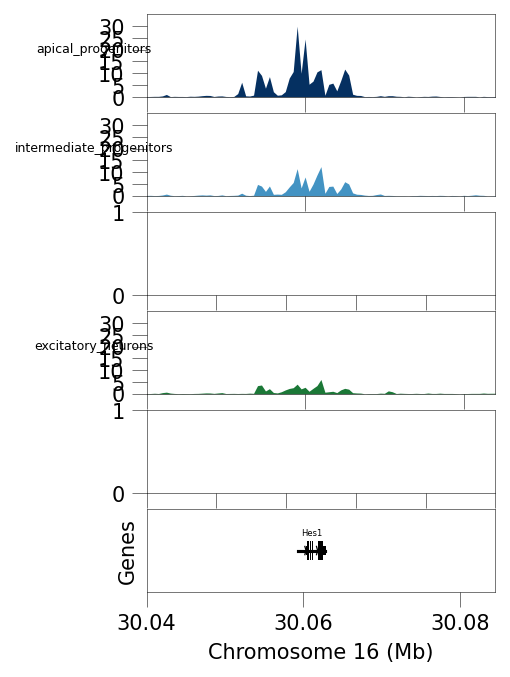

In [78]:
chrom = '16' #Hes1
s = 30045000
e = 30089500

xaxis = np.arange(s,e,binsize)


f, ax = plt.subplots(len(cell_types) + 1, 
                     1, 
                     figsize=(3,5), 
)


ymin, ymax = 0, 35
for i,cell_type in enumerate(cell_types_atac):
    y = gaussian_filter(rpkm_atac[cell_type][chrom][s//binsize:e//binsize], 0)

    if i == 2:
        i += 1
    ax[i].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    
    ax[i].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i].yaxis.set_label_coords(-0.15, 0.5)
    ax[i].margins(x=0)
    ax[i].set_xticks(np.arange(s,e,20_000))
    ax[i].set_xticklabels([])
    
    ax[i].set_ylim(ymin,ymax)
    ax[i].set_yticks(range(ymin,ymax,5))

for i in (2,4):
    ax[i].set_xticklabels([])
genemodel_plotter.plot(ax[-1], chrom, s, e, 12, 1)

ax[-1].set_xticks(np.arange(s,e,20_000))
ax[-1].set_xticklabels(np.round(np.arange(s,e,20_000) / 1e6, 2))
ax[-1].set_xlim(s,e)
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

____

### Genome-wide correlation of ATAC and Dam126

In [85]:
cf_dict_dam126 = dict()
for cell_type in cell_types:
    obs_names = adata.obs[np.ravel(adata.obs['damid']) &
                (adata.obs['cell_type'] == cell_type) & 
                (adata.obs['construct_flattened'] == 'Dam-only')].index
    cf_dict_dam126[cell_type] = {c: np.mean([oe_smooth[obs][c] > 1 for obs in obs_names], axis=0) for c in CHROMS}

In [86]:
X = np.zeros((len(cell_types_atac),len(cell_types)))

for i0,cell_type_atac in enumerate(cell_types_atac):
    X_atac = np.hstack(list(rpkm_atac_100kb[cell_type_atac].values())) 
    for i1,cell_type in enumerate(cell_types):
        X_dam126 = np.hstack(list(cf_dict_dam126[cell_type].values())) 
        p = stats.pearsonr(X_atac, X_dam126)[0]
        X[i0,i1] = p

Text(0, 0.5, 'scATAC')

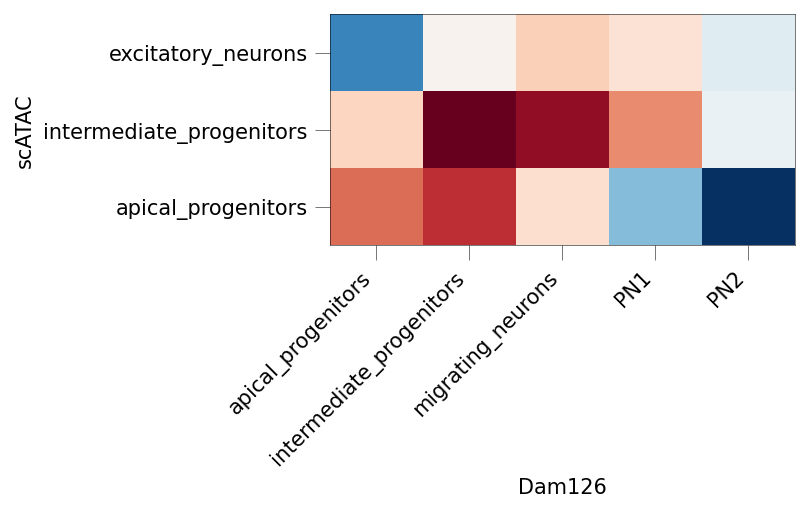

In [87]:
f, ax = plt.subplots(figsize=(4,2))

pcf = ax.pcolorfast(X, cmap='RdBu_r')

ax.set_xticks(np.arange(len(cell_types)) + .5)
ax.set_xticklabels(cell_types, rotation=45, ha='right')
ax.set_yticks(np.arange(len(cell_types_atac)) + .5)
ax.set_yticklabels(cell_types_atac)
ax.set_xlabel('Dam126')
ax.set_ylabel('scATAC')

______

____

# scLADs (Dam-Lamin B1)

In [82]:
cf_dict = dict()
for cell_type in cell_types:
    obs_names = adata.obs[np.ravel(adata.obs['damid']) &
                (adata.obs['cell_type'] == cell_type) & 
                (adata.obs['construct_flattened'] == 'Dam-LMNB1')].index
    cf_dict[cell_type] = {c: np.mean([oe_smooth[obs][c] > 1 for obs in obs_names], axis=0) for c in CHROMS}

Text(0.5, 0, 'Chromosome 12 (Mb)')

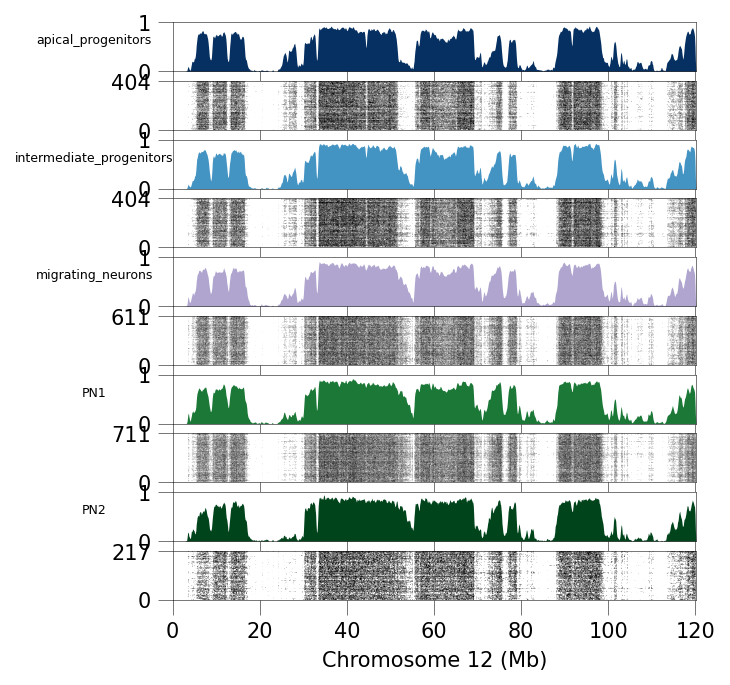

In [83]:
chrom = '12'

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

np.random.seed(0)
f, ax = plt.subplots(len(cell_types) * 2, 
                     1,
                     figsize=(4.5,5)
                    )

for i,cell_type in enumerate(cell_types):
    y = cf_dict[cell_type][chrom]
    obs_names = adata.obs[np.ravel(adata.obs['damid']) &
            (adata.obs['cell_type'] == cell_type) & 
            (adata.obs['construct_flattened'] == 'Dam-LMNB1')].index
    rand_idx = np.random.choice(obs_names.size, obs_names.size, replace=False)
    y2d = np.log2([oe[obs][chrom] for obs in obs_names[rand_idx]])
    
    ax[i*2].fill_between(xaxis, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    ax[(i*2)+1].imshow(y2d, 
                       aspect='auto', 
                       vmin=-1,
                       vmax=1, 
                       cmap='binary',
                       origin='lower',
                       extent=[0,xaxis[-1],0,y2d.shape[0]]
    )
    
    ax[i*2].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i*2].yaxis.set_label_coords(-0.15, 0.5)
    ax[i*2].margins(x=0)
    ax[i*2].set_ylim(0,1)
    ax[(i*2)+1].set_yticks([0,y2d.shape[0]])
    ax[i*2].set_xticklabels([])
    if (i*2)+1 < 9:
        ax[(i*2)+1].set_xticklabels([])
    
ax[-1].set_xlabel(f"Chromosome {chrom} (Mb)")

___

### Marker gene expression

In [88]:
cell_type_order = ['apical_progenitors',
                   'intermediate_progenitors',
                   'migrating_neurons',
                   'PN1',
                   'PN2',
                   'interneurons',
                   'red_blood_cells'
]

In [89]:
np.random.seed(0)

anno['rand_idx'] = np.random.choice(anno.shape[0],anno.shape[0],replace=False)

In [91]:
topn = 15
topn_markers = pd.read_csv('/Users/prullens/Downloads/PR20240925.invivo_seurat_marker_doheatmap.tsv', index_col=0)

In [92]:
cmap_loc = cmap.from_list('',('purple','black','yellow'))

width_ratios = [anno[anno['cell_type'] == cell_type].shape[0] for cell_type in cell_type_order]
f, ax = plt.subplots(2,
                     len(cell_type_order), 
                     figsize=(6,4),
                     gridspec_kw={'height_ratios':[.05,.95],
                                  'width_ratios':width_ratios,
                                  'wspace':.03,
                                  'hspace':.015
                                 }
)

for i,cell_type in enumerate(cell_type_order):
    obs_names = anno[anno['cell_type'] == cell_type].sort_values('rand_idx').index
    X = topn_markers.loc[:,obs_names][::-1]
    
    ax[0,i].set_facecolor(cell_type_colors[cell_type])
    ax[1,i].pcolorfast(X, cmap='magma', vmin=-1, vmax=2)
    
    
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    
ax[1,0].set_yticks(np.arange(topn_markers.shape[0]) + .5)
_ = ax[1,0].set_yticklabels(topn_markers.index[::-1], fontsize=3)

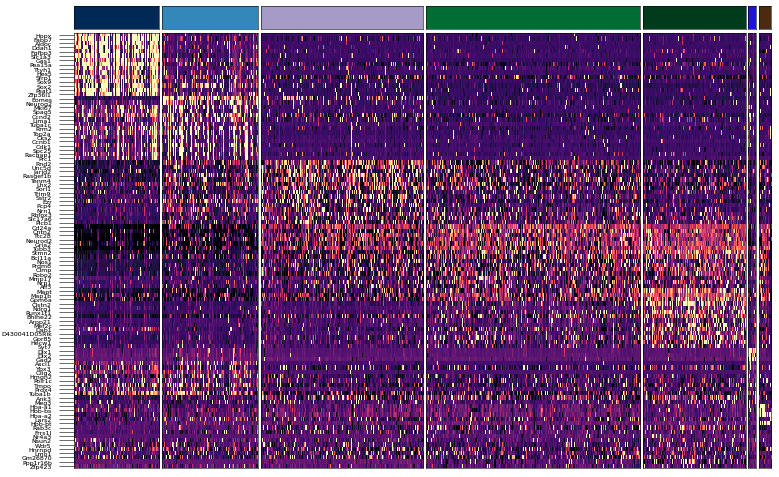

____

### Align genes

In [98]:
rpkm_smooth_scaled_mean = {c: np.mean([rpkm_smooth_scaled[cell_type][c] for cell_type in rpkm_smooth_scaled], 0) for c in CHROMS}

In [101]:
regions = adata.var.iloc[_argsort][['Chromosome','Start','End']].values
strand = adata.var.iloc[_argsort]['Strand'].values

In [102]:
window = 50_000

a2d, bounds = scct.scale_regions(regions, rpkm_smooth_scaled_mean, 500, window, strand=strand)
a2d = gaussian_filter(a2d[bounds], 1)
a2d = a2d[np.argsort(a2d.mean(1))]

a2d.shape

(11325, 300)

Text(0, 0.5, 'Genes')

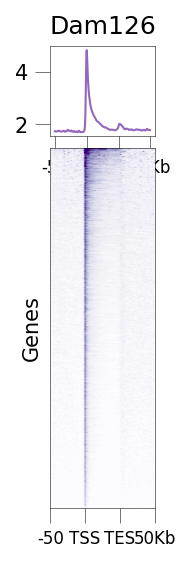

In [103]:
f, ax = plt.subplots(2, 
                     1, 
                     figsize=(.9,4), 
                     gridspec_kw={'height_ratios':[.2,.8],'hspace':.05})

ax[0].plot(a2d.mean(0), lw=1, color=COLORS[4])
ax[1].imshow(a2d, aspect='auto', cmap='Purples', vmin=1.5, vmax=7, origin='lower')

for i in range(ax.size):
    ax[i].set_xticks(np.arange(0,301,100))
    ax[i].set_xticklabels([-50,'TSS','TES','50Kb'], fontsize=8)
ax[1].set_yticks([])
ax[0].set_title('Dam126')
ax[1].set_ylabel('Genes')

### Alignment of LADs

In [105]:
binsize = 10_000

In [106]:
hdf5_list = [DAMIDFN_BASE.format(limsid,limsid,int(i),int(bc),binsize) 
             for limsid,i,bc in adata.obs[(adata.obs['damid'] == True) & 
                                          (adata.obs['construct_flattened'] == 'Dam-LMNB1')][
                 ['limsid','indexnr','damid2_barcodenr']].values
]

len(hdf5_list)

2423

In [107]:
oe_10kb, depths = scct.compute_oe(hdf5_list, 
                             binsize, 
                             CHROMSIZES, 
                             depth_thrs=1_000, 
                             expected=EXPECTED % binsize, 
                             blacklist=BLACKLIST, 
                             chroms=CHROMS
)
len(oe_10kb)

  0%|          | 0/2423 [00:00<?, ?it/s]

2423

In [108]:
oe_10kb_mean = {c: np.mean([oe_10kb[obs][c] for obs in oe_10kb], 0) for c in CHROMS}

In [109]:
window = 500_000

a2d, bounds = scct.scale_regions(npc_lads, oe_10kb_mean, binsize, window)
a2d = gaussian_filter(a2d[bounds], 1)
a2d = a2d[np.argsort(a2d.mean(1))]

a2d.shape

(454, 150)

Text(0, 0.5, 'NPC LADs')

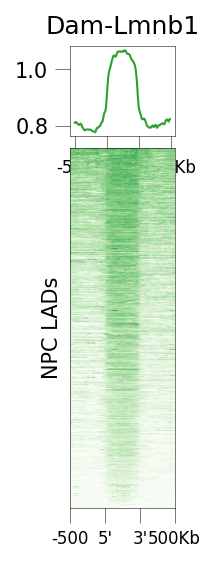

In [110]:
f, ax = plt.subplots(2, 
                     1, 
                     figsize=(.9,4), 
                     gridspec_kw={'height_ratios':[.2,.8],'hspace':.05})

ax[0].plot(a2d.mean(0), color=COLORS[2], lw=1)
ax[1].imshow(a2d, aspect='auto', cmap='Greens', vmin=.55, vmax=2, origin='lower')

for i in range(ax.size):
    ax[i].set_xticks(np.arange(0,151,50))
    ax[i].set_xticklabels([-500,"5'","3'",'500Kb'], fontsize=8)
ax[1].set_yticks([])
ax[0].set_title('Dam-Lmnb1')
ax[1].set_ylabel('NPC LADs')